## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind

## Understanding Data

In [ ]:
data = pd.read_csv("ab_test_results_mock_data.csv")
data.head(5)

,UserID,Group,Date,PageViews,Clicks,Converted
0,UserA_10000,Control,2023-11-08,5,2,0
1,UserA_10001,Control,2023-11-14,8,7,1
2,UserA_10002,Control,2023-11-03,7,6,0
3,UserA_10003,Control,2023-11-06,6,2,0
4,UserA_10004,Control,2023-11-03,6,5,0


In [ ]:
print(data['Group'].unique())

['Control' 'Treatment']


In [ ]:
data.shape

(10000, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   UserID     10000 non-null  object
 1   Group      10000 non-null  object
 2   Date       10000 non-null  object
 3   PageViews  10000 non-null  int64 
 4   Clicks     10000 non-null  int64 
 5   Converted  10000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 468.9+ KB


In [ ]:
# Converting date column to date dataframe

data["Date"] = pd.to_datetime(data["Date"])

In [ ]:
data.isnull().sum()

,0
UserID,0
Group,0
Date,0
PageViews,0
Clicks,0
Converted,0


In [ ]:
# Converting group into 2 distinct groups

Control_group = data[data['Group'] == 'Control']
Treatment_group = data[data['Group'] == 'Treatment']

In [ ]:
print(f"Control group: {len(Control_group)} users")
print(f"Treatment group: {len(Treatment_group)} users")

Control group: 5000 users
Treatment group: 5000 users


## Descriptive Statistics

In [ ]:
# Calculating Conversion rates
control_total_visitors = Control_group['PageViews'].sum()
control_conversions = Control_group['Converted'].sum()
control_conversion_rate = (control_conversions / control_total_visitors) * 100

# For Treatment group
treatment_total_visitors = Treatment_group['PageViews'].sum()
treatment_conversions = Treatment_group['Converted'].sum()
treatment_conversion_rate = (treatment_conversions / treatment_total_visitors) * 100

print(f"Control group conversion rate: {control_conversion_rate:.2f}%")
print(f"Treatment group conversion rate: {treatment_conversion_rate:.2f}%")

Control group conversion rate: 1.01%
Treatment group conversion rate: 1.12%


In [ ]:
# Difference

difference = treatment_conversion_rate - control_conversion_rate
print(f"Difference between treatment and control group: {difference:.2f}%")

Difference between treatment and control group: 0.10%


In [ ]:
# Calculating derived metrics

data['ConversionRate'] = data['Converted'] / data['PageViews']
data['ClickThroughRate'] = data['Clicks'] / data['PageViews']

In [ ]:
# Group-wise statistics
group_stats = data.groupby('Group').agg({
            'PageViews': ['count', 'mean', 'std', 'median'],
            'Clicks': ['sum', 'mean', 'std', 'median'],
            'Converted': ['sum', 'mean', 'std'],
            'ConversionRate': ['mean', 'std', 'median'],
            'ClickThroughRate': ['mean', 'std', 'median']
  }).round(4)

In [ ]:
print(group_stats)

          PageViews                         Clicks                         \
              count     mean     std median    sum    mean     std median   
Group                                                                       
Control        5000   9.4526  4.4499    9.0  34674  6.9348  4.3135    7.0   
Treatment      5000  10.5562  5.0555   11.0  40331  8.0662  4.9282    8.0   

          Converted                 ConversionRate                 \
                sum    mean     std           mean     std median   
Group                                                               
Control         479  0.0958  0.2943         0.0157  0.0697    0.0   
Treatment       590  0.1180  0.3226         0.0167  0.0646    0.0   

          ClickThroughRate                  
                      mean     std  median  
Group                                       
Control             0.6527  0.2498  0.7333  
Treatment           0.6849  0.2395  0.7647  


In [ ]:
# Overall conversion metrics
conversion_summary = data.groupby('Group').agg({
            'PageViews': 'sum',
            'Clicks': 'sum',
            'Converted': 'sum'
        })

In [ ]:
conversion_summary['Overall_ConversionRate'] = (conversion_summary['Converted'] /
                                                       conversion_summary['PageViews'] * 100).round(2)
conversion_summary['Overall_CTR'] = (conversion_summary['Clicks'] /
                                           conversion_summary['PageViews'] * 100).round(2)

print("\nOverall Conversion Metrics:")
print(conversion_summary)


Overall Conversion Metrics:
           PageViews  Clicks  Converted  Overall_ConversionRate  Overall_CTR
Group                                                                       
Control        47263   34674        479                    1.01        73.36
Treatment      52781   40331        590                    1.12        76.41


## Statistical Tests

In [ ]:
#  Contigency Test

control_converted = Control_group['Converted'].sum()
control_not_converted = Control_group['PageViews'].sum() - control_converted
treatment_converted = Treatment_group['Converted'].sum()
treatment_not_converted = Treatment_group['PageViews'].sum() - treatment_converted

In [ ]:
# Making table
np.array([
    [control_converted, control_not_converted],
    [treatment_converted, treatment_not_converted]
])

array([[  479, 46784],
       [  590, 52191]])

### Conversion rate test (chi-square test)

In [ ]:
chi2, p_value_conv, dof, expected = chi2_contingency(np.array([
    [control_converted, control_not_converted],
    [treatment_converted, treatment_not_converted]
]))

In [ ]:
print(f"  • Chi-square statistic: {chi2:.4f}")
print(f"  • P-value: {p_value_conv:.4f}")

  • Chi-square statistic: 2.4706
  • P-value: 0.1160


Statistical Significance: NO

### Click through rate (CTR) test (chi-square test)

In [ ]:
# Click-Through Rate Test

control_ctr = Control_group['Clicks'].sum() / Control_group['PageViews'].sum()
treatment_ctr = Treatment_group['Clicks'].sum() / Treatment_group['PageViews'].sum()

# Chi-square for CTR
control_clicks = Control_group['Clicks'].sum()
control_no_clicks = Control_group['PageViews'].sum() - control_clicks
treatment_clicks = Treatment_group['Clicks'].sum()
treatment_no_clicks = Treatment_group['PageViews'].sum() - treatment_clicks

ctr_contingency = np.array([
            [control_clicks, control_no_clicks],
            [treatment_clicks, treatment_no_clicks]
        ])

chi2_ctr, p_value_ctr, _, _ = chi2_contingency(ctr_contingency)

In [ ]:
print(f"Control CTR: {control_ctr:.4f} ({control_ctr*100:.2f}%)")
print(f"Treatment CTR: {treatment_ctr:.4f} ({treatment_ctr*100:.2f}%)")
print(f"Chi-square statistic: {chi2_ctr:.4f}")
print(f"P-value: {p_value_ctr:.4f}")

Control CTR: 0.7336 (73.36%)
Treatment CTR: 0.7641 (76.41%)
Chi-square statistic: 123.2957
P-value: 0.0000


Statistical Significance: YES

### Test for Page Views (T test)

In [ ]:
# T-Test for Page views
t_stat_pv, p_value_pv = ttest_ind(Control_group['PageViews'], Treatment_group['PageViews'])
print(f"Control PageViews - Mean: {Control_group['PageViews'].mean():.2f}, Std: {Control_group['PageViews'].std():.2f}")
print(f"Treatment PageViews - Mean: {Treatment_group['PageViews'].mean():.2f}, Std: {Treatment_group['PageViews'].std():.2f}")
print(f"T-statistic: {t_stat_pv:.4f}")
print(f"P-value: {p_value_pv:.4f}")

Control PageViews - Mean: 9.45, Std: 4.45
Treatment PageViews - Mean: 10.56, Std: 5.06
T-statistic: -11.5868
P-value: 0.0000


Statistical Significance: YES

## Visualization

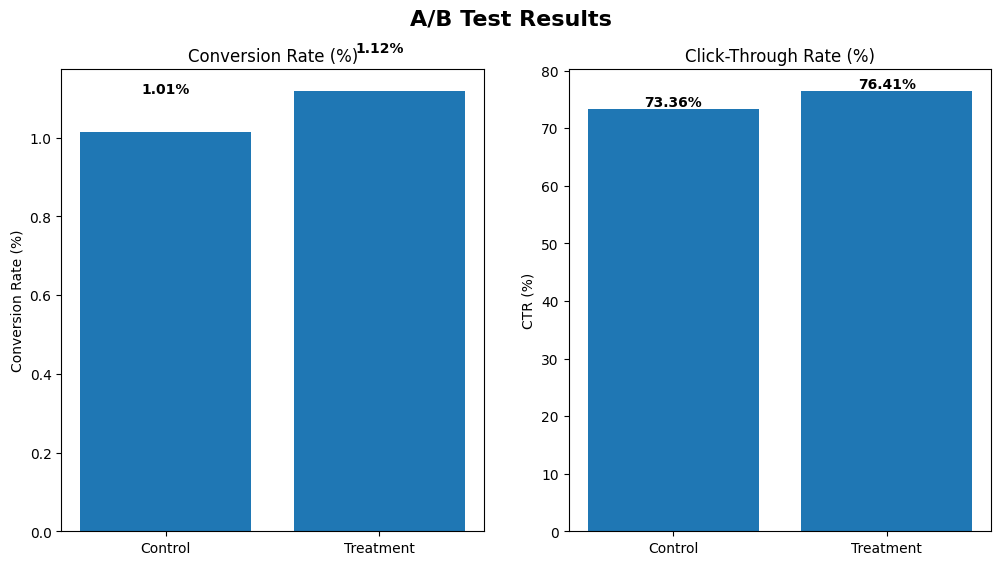

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('A/B Test Results', fontsize=16, fontweight='bold')

# 1. Conversion Rate Comparison
conv_data = data.groupby('Group').agg({
        'PageViews': 'sum',
        'Converted': 'sum'
    })
conv_data['ConversionRate'] = conv_data['Converted'] / conv_data['PageViews'] * 100

axes[0].bar(conv_data.index, conv_data['ConversionRate'])
axes[0].set_title('Conversion Rate (%)')
axes[0].set_ylabel('Conversion Rate (%)')

# Adding value labels on bars
for i, v in enumerate(conv_data['ConversionRate']):
  axes[0].text(i, v + 0.1, f'{v:.2f}%', ha='center', fontweight='bold')

# 2. Click-Through Rate
ctr_data = data.groupby('Group').agg({
        'PageViews': 'sum',
        'Clicks': 'sum'
    })
ctr_data['CTR'] = ctr_data['Clicks'] / ctr_data['PageViews'] * 100

axes[1].bar(ctr_data.index, ctr_data['CTR'])
axes[1].set_title('Click-Through Rate (%)')
axes[1].set_ylabel('CTR (%)')

for i, v in enumerate(ctr_data['CTR']):
  axes[1].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')